# Cucumber Disease Classification Model

This notebook implements an image classification model to identify illnesses in cucumbers using PyTorch and FastAI.


## 1. Import Libraries


In [1]:
# ============================================================================
# IMPORT LIBRARIES
# ============================================================================

# Core PyTorch libraries for building neural networks
import torch                              # PyTorch main library
import torch.nn as nn                     # Neural network modules
import torch.nn.functional as F           # Neural network functions (activations, loss, etc.)
from torch.utils.data import DataLoader, Dataset  # Data loading utilities
import torchvision.transforms as transforms        # Image transformations
from torchvision import models            # Pretrained models (if needed)

# Data handling and visualization
import numpy as np                        # Numerical operations
import pandas as pd                       # Data manipulation (if needed)
import matplotlib.pyplot as plt           # Plotting and visualization
import seaborn as sns                     # Statistical visualization
from PIL import Image                     # Image loading and processing
import pathlib                            # File path handling
import os                                 # Operating system utilities
from collections import Counter, OrderedDict           # Counting utilities
from sklearn.model_selection import train_test_split  # Train/validation split
from sklearn.preprocessing import StandardScaler      # Feature scaling for boosting
from sklearn.ensemble import GradientBoostingClassifier  # Boosting classifier
from sklearn.metrics import confusion_matrix, classification_report, f1_score  # Evaluation metrics
import random                             # Random number generation
import copy                               # Deep copies for checkpoint averaging

# ============================================================================
# CONFIGURATION
# ============================================================================

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility (ensures same results on re-runs)
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.backends.cudnn.deterministic = True

# Check if GPU is available and set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')
if torch.cuda.is_available():
    print(f'GPU: {torch.cuda.get_device_name(0)}')


Using device: cuda
GPU: NVIDIA GeForce RTX 3060 Laptop GPU


## 2. Set Up Data Path and Explore Dataset


Number of classes: 8
Classes: ['Anthracnose', 'Bacterial Wilt', 'Belly Rot', 'Downy Mildew', 'Fresh Cucumber', 'Fresh Leaf', 'Gummy Stem Blight', 'Pythium Fruit Rot']
  Anthracnose: 160 images
  Bacterial Wilt: 160 images
  Belly Rot: 160 images
  Downy Mildew: 160 images
  Fresh Cucumber: 160 images
  Fresh Leaf: 160 images
  Gummy Stem Blight: 160 images
  Pythium Fruit Rot: 169 images

Total number of images: 1289


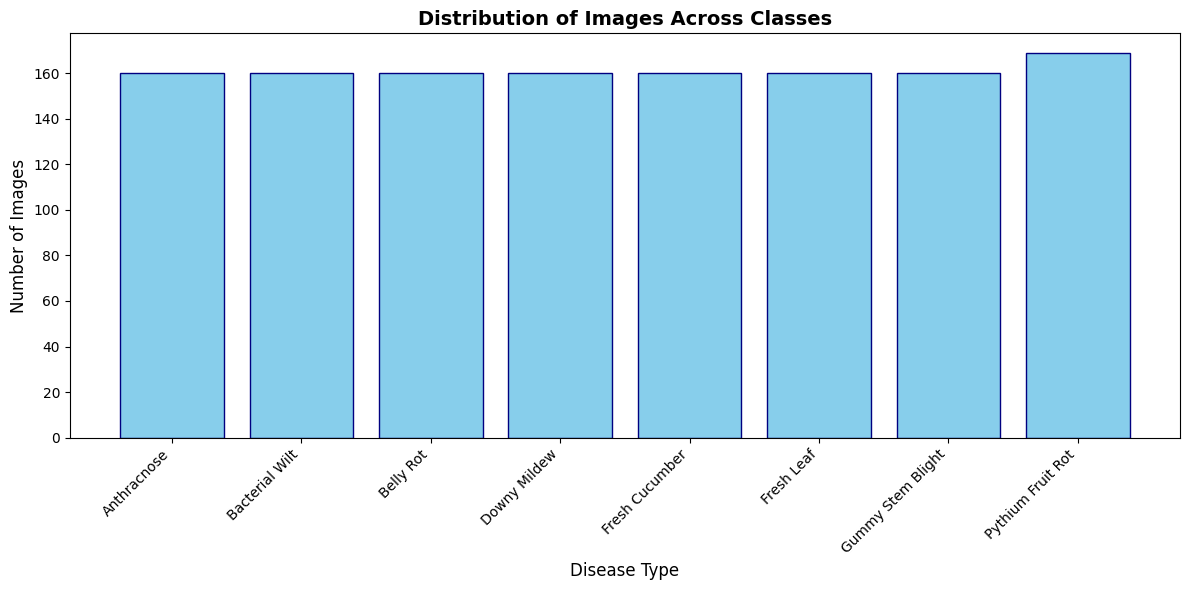

In [2]:
# ============================================================================
# DATA PATH SETUP
# ============================================================================

# Set up the path to the images folder
data_path = pathlib.Path('images')

# Get class names (disease types) by listing all subdirectories in 'imgs'
# Each subdirectory represents one disease category
classes = sorted([d.name for d in data_path.iterdir() if d.is_dir()])
print(f'Number of classes: {len(classes)}')
print(f'Classes: {classes}')

# ============================================================================
# COUNT IMAGES PER CLASS
# ============================================================================

# Define supported image file extensions
image_extensions = ['.jpg', '.jpeg', '.png', '.JPG', '.JPEG', '.PNG']

# Initialize lists to store all image file paths and counts per class
all_image_files = []
class_counts = {}

# Iterate through each class folder and count images
for cls in classes:
    class_path = data_path / cls  # Path to current class folder
    class_images = []
    
    # Loop through all files in the class folder
    for file in class_path.iterdir():
        # Check if it's a valid image file
        if file.is_file() and file.suffix in image_extensions:
            class_images.append(file)
            all_image_files.append(file)
    
    # Store the count for this class
    class_counts[cls] = len(class_images)
    print(f'  {cls}: {len(class_images)} images')

# Print total number of images across all classes
print(f'\nTotal number of images: {len(all_image_files)}')

# ============================================================================
# VISUALIZE CLASS DISTRIBUTION
# ============================================================================

# Create a bar chart showing the number of images per class
plt.figure(figsize=(12, 6))
plt.bar(class_counts.keys(), class_counts.values(), color='skyblue', edgecolor='navy')
plt.xlabel('Disease Type', fontsize=12)
plt.ylabel('Number of Images', fontsize=12)
plt.title('Distribution of Images Across Classes', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')  # Rotate labels for better readability
plt.tight_layout()
plt.show()


## 3. Create Custom PyTorch Dataset and DataLoaders


In [9]:
class CucumberDataset(Dataset):
    """
    Custom PyTorch Dataset for loading cucumber disease images.
    This class handles loading images and applying transformations.
    """
    def __init__(self, image_paths, labels, transform=None):
        """
        Args:
            image_paths: List of paths to image files
            labels: List of integer labels corresponding to each image
            transform: Optional transforms to apply to images
        """
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform
    
    def __len__(self):
        """Returns the total number of samples in the dataset"""
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        """
        Loads and returns a sample (image, label) at the given index.
        Args:
            idx: Index of the sample to retrieve
        Returns:
            image: Transformed image tensor
            label: Integer label for the image
        """
        # Load image from file and ensure it's in RGB format
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]
        
        # Apply transformations if provided (resize, augmentation, normalization)
        if self.transform:
            image = self.transform(image)
        
        return image, label

# ============================================================================
# PREPARE DATA: COLLECT IMAGE PATHS AND LABELS
# ============================================================================

all_image_paths = []
all_labels = []

# Create mappings between class names and integer indices
class_to_idx = {cls: idx for idx, cls in enumerate(classes)}  # e.g., {'Anthracnose': 0, 'Bacterial Wilt': 1, ...}
idx_to_class = {idx: cls for cls, idx in class_to_idx.items()}  # Reverse mapping

# Collect all images from each class folder
for cls in classes:
    class_path = data_path / cls
    # Iterate through all files in the class folder
    for file in class_path.iterdir():
        if file.is_file() and file.suffix in image_extensions:
            all_image_paths.append(file)
            all_labels.append(class_to_idx[cls])  # Assign integer label

print(f'Total images collected: {len(all_image_paths)}')
print(f'Class mapping: {class_to_idx}')

# ============================================================================
# SPLIT DATA INTO TRAINING AND VALIDATION SETS
# ============================================================================

# Split: 80% training, 20% validation
# stratify=all_labels ensures equal class distribution in both sets
train_paths, val_paths, train_labels, val_labels = train_test_split(
    all_image_paths, all_labels, 
    test_size=0.2,           # 20% for validation
    random_state=42,         # For reproducibility
    stratify=all_labels      # Maintain class balance
)

print(f'\nTraining set size: {len(train_paths)}')
print(f'Validation set size: {len(val_paths)}')

# ============================================================================
# DEFINE IMAGE TRANSFORMATIONS
# ============================================================================

# Training transformations: includes data augmentation
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),                              # Resize all images to 256x256
    transforms.RandomHorizontalFlip(p=0.5),                     # Randomly flip images horizontally (50% chance)
    transforms.RandomRotation(degrees=10),                      # Randomly rotate images by ±10 degrees
    transforms.ColorJitter(brightness=0.2, contrast=0.2,        # Randomly adjust brightness, contrast, and saturation
                          saturation=0.2),
    transforms.ToTensor(),                                      # Convert PIL image to PyTorch tensor [0, 1]
    transforms.Normalize(mean=[0.485, 0.456, 0.406],            # Normalize using ImageNet mean and std
                        std=[0.229, 0.224, 0.225])              # Helps with training stability
])

# Validation transformations: NO data augmentation, only resize and normalize
val_transform = transforms.Compose([
    transforms.Resize((256, 256)),                              # Resize to 256x256
    transforms.ToTensor(),                                      # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406],            # Same normalization as training
                        std=[0.229, 0.224, 0.225]) 
])

# ============================================================================
# CREATE DATASETS AND DATALOADERS
# ============================================================================

# Create Dataset objects
train_dataset = CucumberDataset(train_paths, train_labels, transform=train_transform)
val_dataset = CucumberDataset(val_paths, val_labels, transform=val_transform)

# Create DataLoader objects for batching
batch_size = 32
train_loader = DataLoader(
    train_dataset, 
    batch_size=batch_size,   # Number of images per batch
    shuffle=True,            # Shuffle training data each epoch
    num_workers=0            # Set to 0 for Windows compatibility
)
val_loader = DataLoader(
    val_dataset, 
    batch_size=batch_size,   # Same batch size
    shuffle=False,           # Don't shuffle validation data
    num_workers=0
)

print(f'\nNumber of classes: {len(classes)}')
print(f'Batch size: {batch_size}')
print(f'Number of training batches: {len(train_loader)}')
print(f'Number of validation batches: {len(val_loader)}')


Total images collected: 1289
Class mapping: {'Anthracnose': 0, 'Bacterial Wilt': 1, 'Belly Rot': 2, 'Downy Mildew': 3, 'Fresh Cucumber': 4, 'Fresh Leaf': 5, 'Gummy Stem Blight': 6, 'Pythium Fruit Rot': 7}

Training set size: 1031
Validation set size: 258

Number of classes: 8
Batch size: 32
Number of training batches: 33
Number of validation batches: 9


## 4. Visualize Sample Images


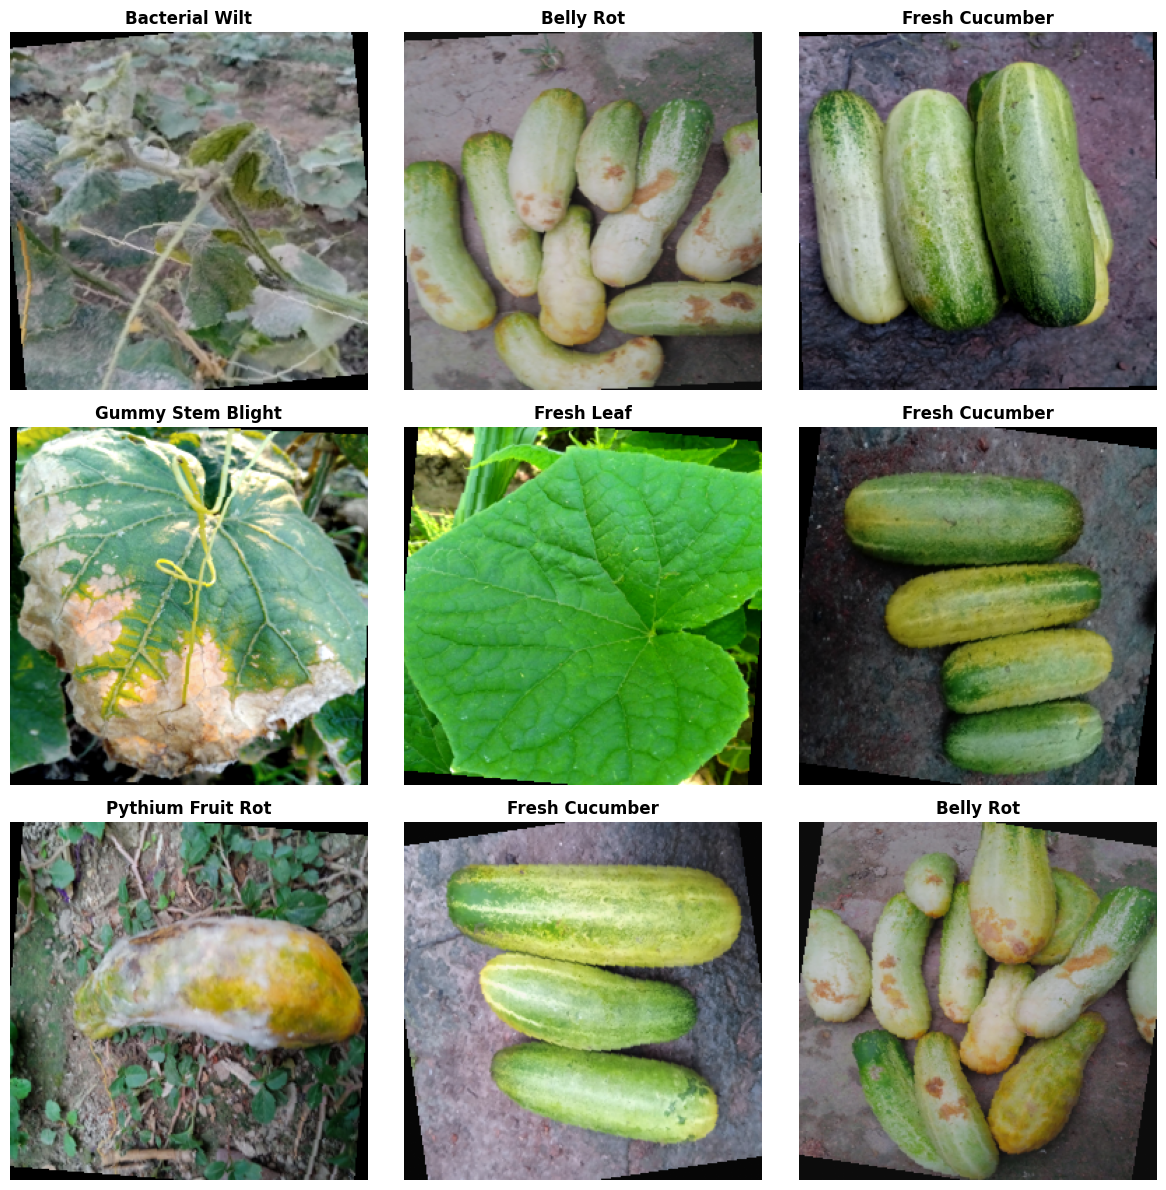

In [10]:
# ============================================================================
# VISUALIZE A BATCH OF TRAINING IMAGES
# ============================================================================

# Get one batch of images from the training loader
dataiter = iter(train_loader)
images, labels = next(dataiter)  # images shape: [batch_size, 3, 256, 256]

# ============================================================================
# DENORMALIZE IMAGES FOR VISUALIZATION
# ============================================================================

def denormalize(tensor, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    """
    Reverse the normalization applied during preprocessing.
    Normalized images have values outside [0, 1] range and can't be displayed properly.
    Formula: pixel = (normalized_pixel * std) + mean
    
    Args:
        tensor: Normalized image tensor
        mean: Mean values used during normalization
        std: Standard deviation values used during normalization
    Returns:
        Denormalized tensor in [0, 1] range
    """
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)  # Reverse: pixel = (pixel * std) + mean
    return tensor

# ============================================================================
# DISPLAY 9 SAMPLE IMAGES IN A 3x3 GRID
# ============================================================================

fig, axes = plt.subplots(3, 3, figsize=(12, 12))
axes = axes.flatten()

for idx in range(9):
    # Denormalize the image (clone to avoid modifying original)
    img = denormalize(images[idx].clone())
    
    # Convert from tensor format [C, H, W] to numpy format [H, W, C]
    img = img.permute(1, 2, 0).cpu().numpy()
    
    # Clip values to [0, 1] range (in case of slight numerical errors)
    img = np.clip(img, 0, 1)
    
    # Display image with its class label
    axes[idx].imshow(img)
    axes[idx].set_title(f'{classes[labels[idx]]}', fontsize=12, fontweight='bold')
    axes[idx].axis('off')

plt.tight_layout()
plt.show()


## 5. Define Custom CNN 

In [11]:

class DepthwiseSeparableStem(nn.Module):
    """Depthwise 3x3 conv followed by pointwise 1x1 conv with spatial downsampling."""
    def __init__(self, in_channels=3, out_channels=32, kernel_size=3, stride=2):
        super().__init__()
        padding = kernel_size // 2
        self.depthwise = nn.Conv2d(
            in_channels,
            in_channels,
            kernel_size=kernel_size,
            stride=stride,
            padding=padding,
            groups=in_channels,
            bias=False
        )
        self.pointwise = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
        self.bn = nn.BatchNorm2d(out_channels)
        self.act = nn.Hardswish()

    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        x = self.bn(x)
        x = self.act(x)
        return x


class Bottleneck(nn.Module):
    """Inverted residual bottleneck block with configurable kernel and stride."""
    def __init__(self, in_channels, out_channels, expand_ratio=4, stride=1, kernel_size=3):
        super().__init__()
        hidden_dim = in_channels * expand_ratio
        padding = kernel_size // 2
        self.use_residual = stride == 1 and in_channels == out_channels

        layers = []
        if expand_ratio != 1:
            layers.extend([
                nn.Conv2d(in_channels, hidden_dim, kernel_size=1, bias=False),
                nn.BatchNorm2d(hidden_dim),
                nn.Hardswish()
            ])

        layers.extend([
            nn.Conv2d(hidden_dim, hidden_dim, kernel_size=kernel_size, stride=stride, padding=padding, groups=hidden_dim, bias=False),
            nn.BatchNorm2d(hidden_dim),
            nn.Hardswish(),
            nn.Conv2d(hidden_dim, out_channels, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_channels)
        ])

        self.block = nn.Sequential(*layers)

    def forward(self, x):
        identity = x
        out = self.block(x)
        if self.use_residual:
            out = out + identity
        return out


class DenseResidualHead(nn.Module):
    """Two-layer dense block with skip connection."""
    def __init__(self, hidden_dim=256, dropout=0.1):
        super().__init__()
        self.fc1 = nn.Linear(hidden_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.act = nn.Hardswish()
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        residual = x
        out = self.fc1(x)
        out = self.act(out)
        out = self.dropout(out)
        out = self.fc2(out)
        out = self.dropout(out)
        out = self.act(out + residual)
        return out


class TanjiroNet(nn.Module):
    """Compact model with aggressive stride-2 downsampling to control memory."""
    def __init__(self, num_classes):
        super().__init__()
        self.stem = DepthwiseSeparableStem(in_channels=3, out_channels=32, stride=2)

        bottleneck_settings = [
            (64, 4, 2, 3),
            (64, 4, 1, 3),
            (96, 4, 2, 3),
            (96, 4, 1, 5),
            (128, 4, 2, 3),
            (128, 4, 1, 5)
        ]

        blocks = []
        in_channels = 32
        for out_channels, expand_ratio, stride, kernel in bottleneck_settings:
            blocks.append(Bottleneck(
                in_channels=in_channels,
                out_channels=out_channels,
                expand_ratio=expand_ratio,
                stride=stride,
                kernel_size=kernel
            ))
            in_channels = out_channels

        self.bottleneck_stack = nn.Sequential(*blocks)
        self.final_channels = in_channels

        self.pool = nn.AdaptiveAvgPool2d((1, 1))

        self.prep_dense = nn.Sequential(
            nn.Flatten(),
            nn.Linear(self.final_channels, 256),
            nn.Hardswish()
        )
        self.dense_block = DenseResidualHead(hidden_dim=256)
        self.classifier = nn.Linear(256, num_classes)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.stem(x)
        x = self.bottleneck_stack(x)
        x = self.pool(x)
        x = self.prep_dense(x)
        x = self.dense_block(x)
        logits = self.classifier(x)
        probs = self.softmax(logits)
        return probs


model = TanjiroNet(num_classes=len(classes)).to(device)
dummy_input = torch.randn(1, 3, 256, 256).to(device)
with torch.no_grad():
    dummy_output = model(dummy_input)

print(model)
print(f"Output shape (dummy batch): {dummy_output.shape}")
print('='*50)
print(f"Total parameters: {sum(p.numel() for p in model.parameters())/1e6:.2f} million")


TanjiroNet(
  (stem): DepthwiseSeparableStem(
    (depthwise): Conv2d(3, 3, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=3, bias=False)
    (pointwise): Conv2d(3, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act): Hardswish()
  )
  (bottleneck_stack): Sequential(
    (0): Bottleneck(
      (block): Sequential(
        (0): Conv2d(32, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Hardswish()
        (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=128, bias=False)
        (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): Hardswish()
        (6): Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runnin

## 6. Training Configuration and Utilities


In [12]:

initial_epochs = 30
secondary_epochs = 30
total_epochs = initial_epochs + secondary_epochs
learning_rate = 5e-4 #
weight_decay = 1e-4
label_smoothing = 0.01

criterion = nn.CrossEntropyLoss(label_smoothing=label_smoothing)

print(
    f"Stage 1: {initial_epochs} epochs | Stage 2: {secondary_epochs} epochs | "
    f"base lr={learning_rate} | weight_decay={weight_decay} | "
    f"label smoothing={label_smoothing}"
)

# ============================================================================
# HELPER FUNCTIONS
# ============================================================================

def compute_f1(y_true, y_pred):
    """Compute  F1 score using sklearn."""
    return f1_score(y_true, y_pred, average='weighted')


def evaluate(model, dataloader, criterion, device=device, return_preds=False):
    """Evaluate model on a dataloader; optionally return predictions."""
    model.eval()
    running_loss = 0.0
    all_targets = []
    all_predictions = []

    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs = inputs.to(device)
            targets = targets.to(device)

            outputs = model(inputs)  # logits
            loss = criterion(outputs, targets)

            running_loss += loss.item() * inputs.size(0)
            preds = torch.argmax(outputs, dim=1)
            all_targets.extend(targets.cpu().numpy())
            all_predictions.extend(preds.cpu().numpy())

    avg_loss = running_loss / len(dataloader.dataset)
    avg_f1 = compute_f1(all_targets, all_predictions)

    if return_preds:
        return avg_loss, avg_f1, np.array(all_targets), np.array(all_predictions)
    return avg_loss, avg_f1


def average_state_dicts(state_dicts):
    """Average a list of state dicts (assumes identical keys)."""
    if not state_dicts:
        raise ValueError("state_dicts list is empty")
    avg_state = OrderedDict()
    num_models = len(state_dicts)
    for key in state_dicts[0].keys():
        avg_state[key] = sum(sd[key] for sd in state_dicts) / num_models
    return avg_state


tta_transforms = [
    lambda x: torch.flip(x, dims=[3]),            # horizontal flip
    lambda x: torch.flip(x, dims=[2]),            # vertical flip
    lambda x: torch.rot90(x, k=1, dims=[2, 3]),   # 90° rotation
    lambda x: torch.rot90(x, k=3, dims=[2, 3])    # 270° rotation
]


def evaluate_with_tta(model, dataloader, criterion, device=device, transforms=None, return_preds=False):
    """Evaluate with test-time augmentation by averaging logits across transforms."""
    model.eval()
    running_loss = 0.0
    all_targets = []
    all_predictions = []
    transforms = transforms or []
    num_views = len(transforms) + 1

    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs = inputs.to(device)
            targets = targets.to(device)

            logits_sum = model(inputs)
            for fn in transforms:
                aug_inputs = fn(inputs)
                logits_sum += model(aug_inputs)

            avg_logits = logits_sum / num_views
            loss = criterion(avg_logits, targets)

            running_loss += loss.item() * inputs.size(0)
            preds = torch.argmax(avg_logits, dim=1)
            all_targets.extend(targets.cpu().numpy())
            all_predictions.extend(preds.cpu().numpy())

    avg_loss = running_loss / len(dataloader.dataset)
    avg_f1 = compute_f1(all_targets, all_predictions)

    if return_preds:
        return avg_loss, avg_f1, np.array(all_targets), np.array(all_predictions)
    return avg_loss, avg_f1



Stage 1: 30 epochs | Stage 2: 30 epochs | base lr=0.0005 | weight_decay=0.0001 | label smoothing=0.01


## 7. Train the Model


In [7]:
torch.cuda.empty_cache()
torch.cuda.memory_summary(device=None, abbreviated=False)

'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      |  11420 KiB |  21532 KiB | 115982 KiB | 104562 KiB |\n|       from large pool |   8320 KiB |  18432 KiB |  96896 KiB |  88576 KiB |\n|       from small pool |   3100 KiB |   6173 KiB |  19086 KiB |  15986 KiB |\n|---------------------------------------------------------------------------|\n| Active memory         |  11420 KiB |  21532 KiB | 115982 KiB | 104562 KiB |\n|       from large pool |   8320 KiB |  18432 KiB |

In [13]:
history = {'train_loss': [], 'val_loss': [], 'val_f1': []}
best_val_f1 = 0.0
best_state_dict = None
top_checkpoints = []
global_epoch = 0

# -------------------------------
# Stage 1: primary training (30 ep)
# -------------------------------
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=initial_epochs)

for epoch in range(1, initial_epochs + 1):
    global_epoch += 1
    model.train()
    running_loss = 0.0

    for inputs, targets in train_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

    scheduler.step()

    train_loss = running_loss / len(train_loader.dataset)
    val_loss, val_f1 = evaluate(model, val_loader, criterion, device=device)

    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['val_f1'].append(val_f1)

    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        best_state_dict = copy.deepcopy(model.state_dict())

    snapshot = OrderedDict((k, v.detach().cpu().clone()) for k, v in model.state_dict().items())

    current_lr = scheduler.get_last_lr()[0]
    print(
        f"Stage 1 | Epoch [{global_epoch}/{total_epochs}] | LR: {current_lr:.2e} | "
        f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val F1: {val_f1:.4f}"
    )

# Average the top-k checkpoints for a stronger starting point
if top_checkpoints:
    avg_state = average_state_dicts([ckpt for _, ckpt in top_checkpoints])
    model.load_state_dict(avg_state)
    print(f"\nLoaded averaged checkpoint from top {len(top_checkpoints)} snapshots (Stage 1)")

# -------------------------------
# Stage 2: fine-tuning (30 ep)
# -------------------------------
if secondary_epochs > 0:
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=secondary_epochs)
    if best_state_dict is not None:
        model.load_state_dict(best_state_dict)
        print(f"\nLoaded best model weights overall (Val F1 = {best_val_f1:.4f})")

        for epoch in range(1, secondary_epochs + 1):
            global_epoch += 1
            model.train()
            running_loss = 0.0

            for inputs, targets in train_loader:
                inputs = inputs.to(device)
                targets = targets.to(device)

                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
                optimizer.step()

                running_loss += loss.item() * inputs.size(0)

            scheduler.step()

            train_loss = running_loss / len(train_loader.dataset)
            val_loss, val_f1 = evaluate(model, val_loader, criterion, device=device)

            history['train_loss'].append(train_loss)
            history['val_loss'].append(val_loss)
            history['val_f1'].append(val_f1)

            if val_f1 > best_val_f1:
                best_val_f1 = val_f1
                best_state_dict = copy.deepcopy(model.state_dict())

            current_lr = scheduler.get_last_lr()[0]
            print(
                f"Stage 2 | Epoch [{global_epoch}/{total_epochs}] | LR: {current_lr:.2e} | "
                f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val F1: {val_f1:.4f}"
            )

# Load best weights based on validation F1


Stage 1 | Epoch [1/60] | LR: 4.99e-04 | Train Loss: 1.9866 | Val Loss: 2.0154 | Val F1: 0.1370
Stage 1 | Epoch [2/60] | LR: 4.95e-04 | Train Loss: 1.7854 | Val Loss: 1.7747 | Val F1: 0.4106
Stage 1 | Epoch [3/60] | LR: 4.88e-04 | Train Loss: 1.7188 | Val Loss: 1.6601 | Val F1: 0.5633
Stage 1 | Epoch [4/60] | LR: 4.78e-04 | Train Loss: 1.7028 | Val Loss: 1.6717 | Val F1: 0.5614
Stage 1 | Epoch [5/60] | LR: 4.67e-04 | Train Loss: 1.6766 | Val Loss: 1.6253 | Val F1: 0.6148
Stage 1 | Epoch [6/60] | LR: 4.52e-04 | Train Loss: 1.6570 | Val Loss: 1.6459 | Val F1: 0.5755
Stage 1 | Epoch [7/60] | LR: 4.36e-04 | Train Loss: 1.6520 | Val Loss: 1.5996 | Val F1: 0.6313
Stage 1 | Epoch [8/60] | LR: 4.17e-04 | Train Loss: 1.6392 | Val Loss: 1.6046 | Val F1: 0.6410
Stage 1 | Epoch [9/60] | LR: 3.97e-04 | Train Loss: 1.6065 | Val Loss: 1.6229 | Val F1: 0.6347
Stage 1 | Epoch [10/60] | LR: 3.75e-04 | Train Loss: 1.6040 | Val Loss: 1.6679 | Val F1: 0.5765
Stage 1 | Epoch [11/60] | LR: 3.52e-04 | Train Lo

## 8. Evaluation, Confusion Matrix, and Metrics



Loaded best model weights overall (Val F1 = 0.8172)
=== Standard Validation ===
Loss: 1.4570 | Accuracy: 0.8256 | Macro F1: 0.8172


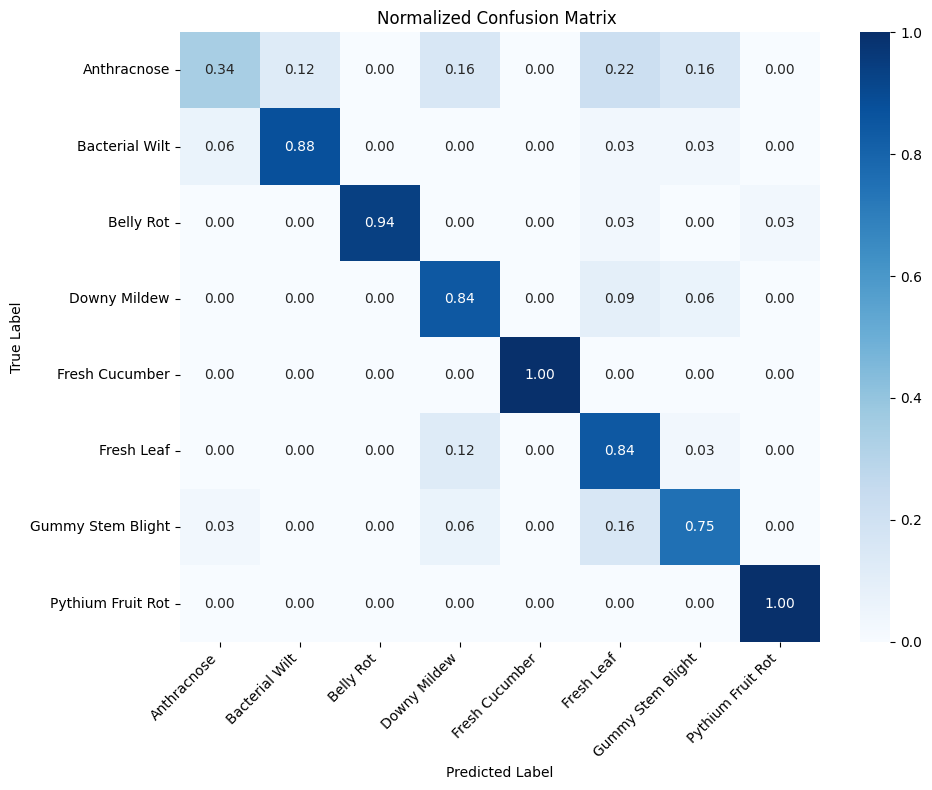


Classification Report:
                   precision    recall  f1-score   support

      Anthracnose       0.79      0.34      0.48        32
   Bacterial Wilt       0.88      0.88      0.88        32
        Belly Rot       1.00      0.94      0.97        32
     Downy Mildew       0.71      0.84      0.77        32
   Fresh Cucumber       1.00      1.00      1.00        32
       Fresh Leaf       0.61      0.84      0.71        32
Gummy Stem Blight       0.73      0.75      0.74        32
Pythium Fruit Rot       0.97      1.00      0.99        34

         accuracy                           0.83       258
        macro avg       0.84      0.82      0.82       258
     weighted avg       0.84      0.83      0.82       258



In [14]:
if best_state_dict is not None:
        model.load_state_dict(best_state_dict)
        print(f"\nLoaded best model weights overall (Val F1 = {best_val_f1:.4f})")
val_loss, val_f1, y_true, y_pred = evaluate(model, val_loader, criterion, device=device, return_preds=True)

accuracy = (y_true == y_pred).mean()

print("=== Standard Validation ===")
print(f"Loss: {val_loss:.4f} | Accuracy: {accuracy:.4f} | Macro F1: {val_f1:.4f}")

cm = confusion_matrix(y_true, y_pred)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(10, 8))
sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title('Normalized Confusion Matrix ')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=classes))


## 9. Training Curves and Metric Visualization


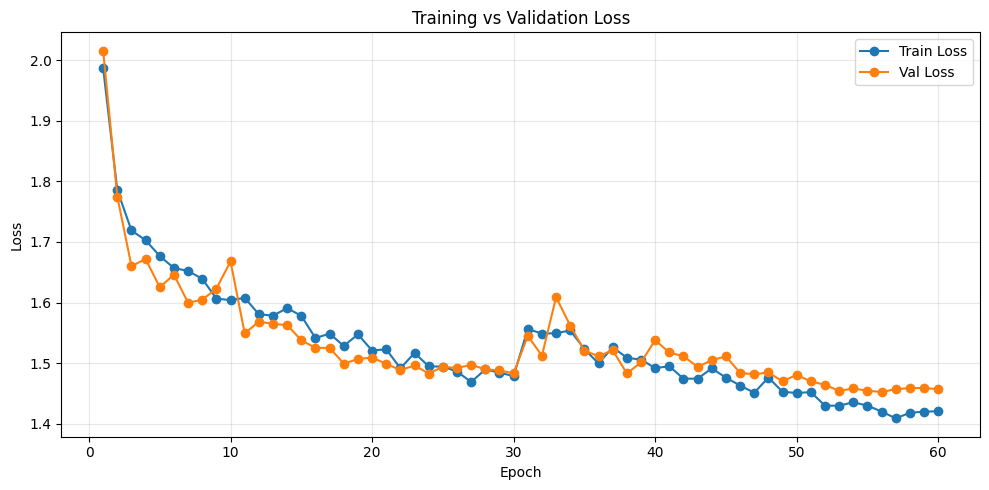

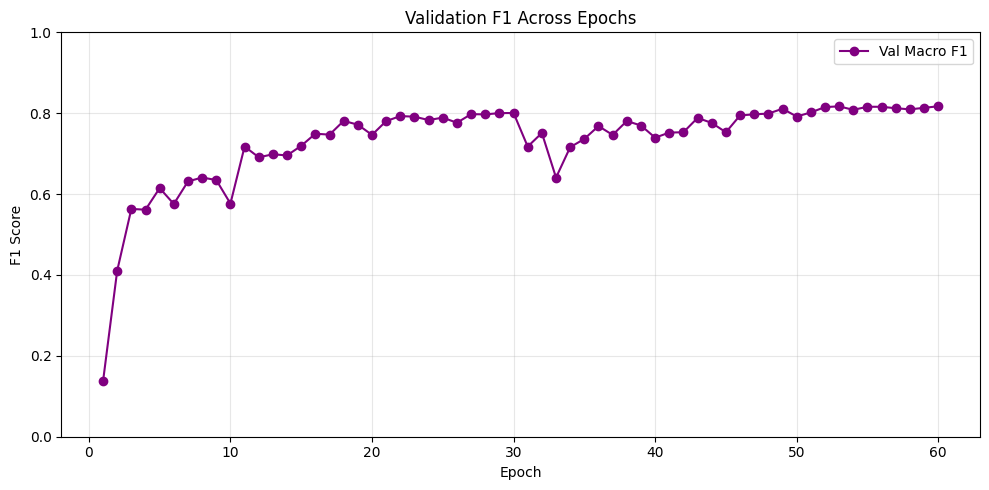

In [15]:
epochs = range(1, len(history['train_loss']) + 1)

plt.figure(figsize=(10, 5))
plt.plot(epochs, history['train_loss'], label='Train Loss', marker='o')
plt.plot(epochs, history['val_loss'], label='Val Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(epochs, history['val_f1'], label='Val Macro F1', color='purple', marker='o')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.ylim(0, 1)
plt.title('Validation F1 Across Epochs')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()
